In [8]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import datetime
import os

En este notebook se efectúa el tratamiento básico de los datos para mostrarlo en las diversas gráficas en la aplicación, a través del código generado en este archivo se ha generado la función presente en utils.data_cleaning_utils.py
# Indice 

### [Sección 1: Data loading and cleaning](#Seccion-1-Data-Loading-and-Cleaning)
### [Sección 2: Regression approach](#Seccion-2-Regression-Approach)



# Seccion 1 Data Loading and Cleaning

Carga de los datos y definición de los infotipos de cada columna según necesidad:

In [9]:
path= os.path.join('Analisis', 'data_frame.gzip')
df= pd.read_parquet(path)

In [11]:
df[['Serial Number', 'List Year']]= df[['Serial Number', 'List Year']].astype(int)
df[['Assessed Value', 'Sale Amount', 'Sales Ratio']]= df[['Assessed Value', 'Sale Amount', 'Sales Ratio']].astype(float)

df

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.535400,Residential,Single Family,nan,nan,nan,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.460600,Residential,Three Family,nan,nan,nan,nan
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.463000,Commercial,nan,nan,nan,nan,nan
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.629100,Residential,Two Family,nan,nan,nan,nan
4,200500,2020,09/07/2021,Avon,245 NEW ROAD,217640.0,400000.0,0.544100,Residential,Single Family,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997208,190272,2019,06/24/2020,New London,4 BISHOP CT,60410.0,53100.0,1.137665,Single Family,Single Family,14 - Foreclosure,nan,nan,nan
997209,190284,2019,11/27/2019,Waterbury,126 PERKINS AVE,68280.0,76000.0,0.898400,Single Family,Single Family,25 - Other,PRIVATE SALE,nan,nan
997210,190129,2019,04/27/2020,Windsor Locks,19 HATHAWAY ST,121450.0,210000.0,0.578300,Single Family,Single Family,nan,nan,nan,nan
997211,190504,2019,06/03/2020,Middletown,8 BYSTREK DR,203360.0,280000.0,0.726300,Single Family,Single Family,nan,nan,nan,nan


A continuación obtenemos algunos features adicionales:

In [13]:
df= df[df['Date Recorded'].apply(lambda x: len(x)) == 10]


df['year']= df['Date Recorded'].apply(lambda x: x[6:]).copy()
df['month']= df['Date Recorded'].apply(lambda x: x[3:5]).copy()
df['day']= df['Date Recorded'].apply(lambda x: x[:2]).copy()




Eliminamos algunos datos que no tienen sentido, como mes superior a 12:

In [15]:
df= df[(df['month'].astype(int) <= 12) & (df['day'].astype(int) != 0)]


Adicionalmente obtenemos si el registro de la venta se ha producido en fin de semana o entre semana:

In [16]:
df['is_weekend']= df[['year', 'month', 'day']].astype(int).apply(lambda x: datetime.date(*x.values.tolist()).weekday(), axis=1)
df['is_weekend']= df['is_weekend'].apply(lambda x: 1 if x in (6, 7) else 0)
df['is_weekend']

4         0
6         0
9         0
15        0
17        0
         ..
997197    0
997199    0
997205    0
997207    1
997211    0
Name: is_weekend, Length: 385643, dtype: int64

Obtenemos la matriz de correlaciones para las variables:

In [18]:
df.corr(numeric_only= True)

,Serial Number,List Year,Assessed Value,Sale Amount,Sales Ratio,is_weekend
Serial Number,1.000000,0.086949,-0.001450,0.001049,-0.000375,-0.001443
List Year,0.086949,1.000000,0.034909,0.020230,-0.004364,0.014362
Assessed Value,-0.001450,0.034909,1.000000,0.348077,0.006065,0.001530
Sale Amount,0.001049,0.020230,0.348077,1.000000,-0.000993,0.009339
Sales Ratio,-0.000375,-0.004364,0.006065,-0.000993,1.000000,0.001186
is_weekend,-0.001443,0.014362,0.001530,0.009339,0.001186,1.000000


Obtenemos en una columna el mes y el año concatenados:

In [19]:
df['year_and_month']= df['year'] + '/' + df['month']

In [ ]:
Gráfica temporal con los valores medios mensuales del precio tasado:

In [20]:
df_sales_stat= pd.DataFrame(df[['year_and_month', 'Assessed Value']].groupby('year_and_month').mean()['Assessed Value'])
fig= go.Figure(data= [
                        go.Scatter(x= df_sales_stat.index, y= df_sales_stat.iloc[:, 0], mode= 'markers+lines')

])
fig.show()

Recuento de viviendas vendidas por cada tipología:

In [21]:
df['Residential Type'].value_counts()

Residential Type
Single Family    170214
nan              151316
Condo             46102
Two Family        11659
Three Family       5414
Four Family         938
Name: count, dtype: int64

12 localidades con los precios de venta más caros, en la aplicación figura este gráfico en función de varios indicadores:

In [23]:
df_expensive_towns= df[['Town', 'Assessed Value', 'Sale Amount', 'Sales Ratio']].groupby('Town').mean().sort_values(by= 'Sale Amount', ascending= True)
df_expensive_towns= df_expensive_towns.iloc[-12:].sort_values(by= 'Sale Amount', ascending= True)
fig = go.Figure([go.Bar(y= df_expensive_towns['Sale Amount'], x=list(df_expensive_towns.index))])
fig.show()

## Seccion 2 Regression Approach

**In this section, we will try to predict with an extrem gradient boosting method the Sale Amount price in dollars of each house**
**Load the data set with the coordinates integrated:**

In [140]:
df= pd.read_parquet(r'Analisis/datos_finales')
df.sample(5)

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Full Address,Longitude,Latitude
93288,70085,2007,07/01/2008,Old Lyme,48 SALTAIRE DR,390600.0,850000.0,0.459529,Single Family,"48 SALTAIRE DR,Old Lyme",-72.272838,41.286540
140852,90301,2009,09/01/2010,New Canaan,17 DANFORTH DRIVE,783300.0,1120000.0,0.699375,Single Family,"17 DANFORTH DRIVE,New Canaan",-73.486215,41.205478
344818,170241,2017,08/07/2018,Clinton,2 OAKWOOD LN,104200.0,210000.0,0.496100,Single Family,"2 OAKWOOD LN,Clinton",NaN,NaN
420306,1900166,2019,11/01/2019,Stamford,236 SEATON ROAD # 29-D-1,113520.0,195000.0,0.582200,Condo,"236 SEATON ROAD # 29-D-1,Stamford",NaN,NaN
402196,19079,2019,07/20/2020,Salisbury,53 FALLS MOUNTAIN ROAD,944790.0,1175000.0,0.804100,Single Family,"53 FALLS MOUNTAIN ROAD,Salisbury",NaN,NaN


**Let´s delete some features that do not have associated latitude and longitude data:**

In [141]:
df= df[~(df['Longitude'].isna()) & ~(df['Latitude'].isna())]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 347788 entries, 1 to 429568
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Serial Number   347788 non-null  int64  
 1   List Year       347788 non-null  int64  
 2   Date Recorded   347788 non-null  object 
 3   Town            347788 non-null  object 
 4   Address         347788 non-null  object 
 5   Assessed Value  347788 non-null  float64
 6   Sale Amount     347788 non-null  float64
 7   Sales Ratio     347788 non-null  float64
 8   Property Type   347788 non-null  object 
 9   Full Address    347788 non-null  object 
 10  Longitude       347788 non-null  float64
 11  Latitude        347788 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 34.5+ MB


**Lets obtain additional info about the  data:**

In [142]:
df['Year Recorded'], df['Month Recorded'] = df['Date Recorded'].apply(lambda x: x.split('/')[-1]).astype(int), df['Date Recorded'].apply(lambda x: x.split('/')[-3]).astype(int)
df.drop(columns= ['Date Recorded'], inplace= True)
df.reset_index(drop= True, inplace= True)

**Also, lets filter some values that are sparse**

In [145]:
mask_1 = df['Property Type'].value_counts()/df.shape[0] > .05
mask_2 = df['Town'].value_counts()/df.shape[0] > .1

df= df[df['Property Type'].isin(mask_1.index) & df['Town'].isin(mask_2.index)]

df.drop(columns= ['Address', 'Full Address', 'Serial Number', 'Town'], inplace= True) # -> this info is already contained in the longitude and latitude
df= pd.get_dummies(df)
# get cathegorical features as numbers:
df= df.astype(float)
df

,List Year,Assessed Value,Sale Amount,Sales Ratio,Longitude,Latitude,Year Recorded,Month Recorded,Property Type_Apartments,Property Type_Commercial,Property Type_Condo,Property Type_Four Family,Property Type_Industrial,Property Type_Public Utility,Property Type_Single Family,Property Type_Three Family,Property Type_Two Family,Property Type_Vacant Land
0,2020.0,253000.0,430000.0,0.5883,-72.207310,41.917736,2020.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2020.0,130400.0,179900.0,0.7248,-72.875941,41.771014,2021.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020.0,619290.0,890000.0,0.6958,-72.902562,41.790468,2021.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2020.0,862330.0,1447500.0,0.5957,-72.805994,41.797235,2021.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2020.0,847520.0,1250000.0,0.6780,-72.805611,41.796180,2020.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347783,2019.0,77870.0,112000.0,0.6953,-73.023781,41.552075,2019.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
347784,2019.0,306000.0,456000.0,0.6711,-72.714886,41.656207,2020.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
347785,2019.0,125230.0,246000.0,0.5091,-72.933610,41.359730,2019.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
347786,2019.0,121450.0,210000.0,0.5783,-72.655454,41.933305,2020.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Now, we will define the input feature columns

In [146]:
x_cols= [col for col in cols if col not in ['Sale Amount', 'Sales Ratio']]
x_cols

['List Year',
 'Assessed Value',
 'Longitude',
 'Latitude',
 'Year Recorded',
 'Month Recorded',
 'Property Type_Apartments',
 'Property Type_Commercial',
 'Property Type_Condo',
 'Property Type_Four Family',
 'Property Type_Industrial',
 'Property Type_Public Utility',
 'Property Type_Single Family',
 'Property Type_Three Family',
 'Property Type_Two Family',
 'Property Type_Vacant Land']

First, lets perform a shallow grid search with the less important hyperparemters (ej.: reg lambda, reg alpha, optimization algorith, etc):

Enlaces de interés: 
- **[Optimal params for the model are listed here](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/#:~:text=The%20three%20main%20hyperparameters%20in,and%20performance%20of%20the%20model.)**
- **[Full math description here](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)**

In [156]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

xgb= XGBRegressor(tree_method='gpu_hist') # -> enables GPU

# full math description here: https://xgboost.readthedocs.io/en/stable/tutorials/model.html

param_grid = {
        'min_child_weight': [1, 5, 10], #> min sum of observations required in a child
        'gamma': [0.5, 1.5, 5], # -> entropy/loss reduction to to perform a node split in given estimator 
        'eta' : [.05, .1, .2], # el learning rate de to la vida illo
        'subsample': [0.6, 0.8, 1.0], # fraction of observation to train each tree
        # 'lambda': [.1, .5, .8], # Regularization lamda term L2
        # 'alpha': [0, .5, .8] # Regularization term alpha L1 

        }

df_train= df.loc[np.random.randint(len(df), size= (1000))]

# lets define train and test partitions stratifying in the sell price:
X_train, X_test, y_train, y_test = train_test_split(df_train[x_cols], df_train['Sale Amount'], test_size=0.2, random_state=42)
# fit the model


Let´s perform the grid search for the first batch of hyperparemeters:

In [157]:
grid_search = GridSearchCV(xgb, param_grid, scoring='r2', verbose= True) #-> we 
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'eta': [0.05, 0.1, 0.2], 'gamma': [0.5, 1.5, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='r2', verbose=True)

In [159]:
params= grid_search.best_params_
params

{'eta': 0.05, 'gamma': 0.5, 'min_child_weight': 1, 'subsample': 0.6}

In [161]:
grid_search.best_score_

0.9182535484055716

**Now, lets find the number of total estimator and max depth tree (It controls the depth of each decision tree in the ensemble), a really important hyperparemeter in xgboost algorithm.**

To improve this two key, the concept of learning curves will be used:

In [207]:
mae, r2, mape= [], [], []
range_n_estimators= list(range(50, 2000, 100))
for n_estimators in range_n_estimators:
        params['n_estimators']= n_estimators
        params['tree_method']= 'gpu_hist'
        
        xgb= XGBRegressor(**params) # -> enables multiple threads in paralell
        xgb.fit(X_train, y_train)
        pred= xgb.predict(X_test)
        # measures:
        mae+= [mean_absolute_error(pred, y_test)]
        r2+= [r2_score(pred, y_test)]
        mape+= [mean_absolute_percentage_error(pred, y_test)]



 best n_estimator per indicator:

R2
150

mae
150

mape
150



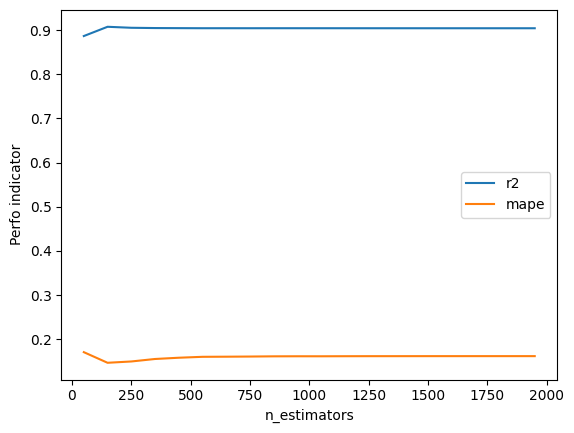

In [208]:
%matplotlib inline

plt.plot(range_n_estimators, r2, range_n_estimators, mape)
plt.legend(['r2', 'mape'])
plt.xlabel('n_estimators')
plt.ylabel('Perfo indicator')


print(f""" best n_estimator per indicator:\n\nR2
{range_n_estimators[np.array(r2).argmax()]}
\nmae
{range_n_estimators[np.array(mae).argmin()]}
\nmape
{range_n_estimators[np.array(mape).argmin()]}
""")
params['n_estimators']= 150

In [209]:
mae, r2, mape= [], [], []
range_n_depth= list(range(3, 15, 2))
for max_depth in range_n_depth:
        params['max_depth']= max_depth
        
        xgb= XGBRegressor(**params) # -> enables multiple threads in paralell
        xgb.fit(X_train, y_train)
        pred= xgb.predict(X_test)
        # measures:
        mae+= [mean_absolute_error(pred, y_test)]
        r2+= [r2_score(pred, y_test)]
        mape+= [mean_absolute_percentage_error(pred, y_test)]


 best max_depth per indicator:

R2
3

mae
7

mape
7



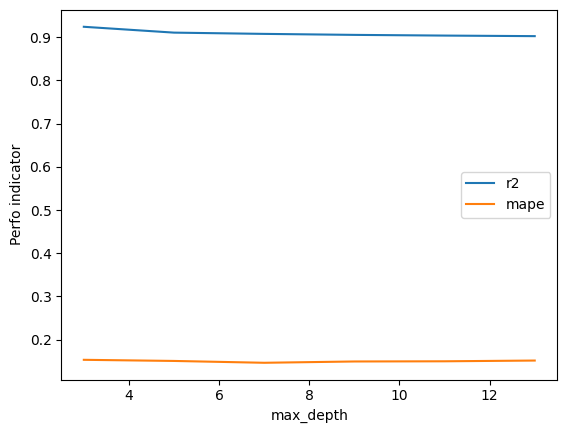

In [198]:
%matplotlib inline

plt.plot(range_n_depth, r2, range_n_depth, mape)
plt.legend(['r2', 'mape'])
plt.xlabel('max_depth')
plt.ylabel('Perfo indicator')



print(f""" best max_depth per indicator:\n\nR2
{range_n_depth[np.array(r2).argmax()]}
\nmae
{range_n_depth[np.array(mae).argmin()]}
\nmape
{range_n_depth[np.array(mape).argmin()]}
""")
params['max_depth']= 7

**Finally, the model importances will be assessed, as observed, the most important feature is the assessed value:**

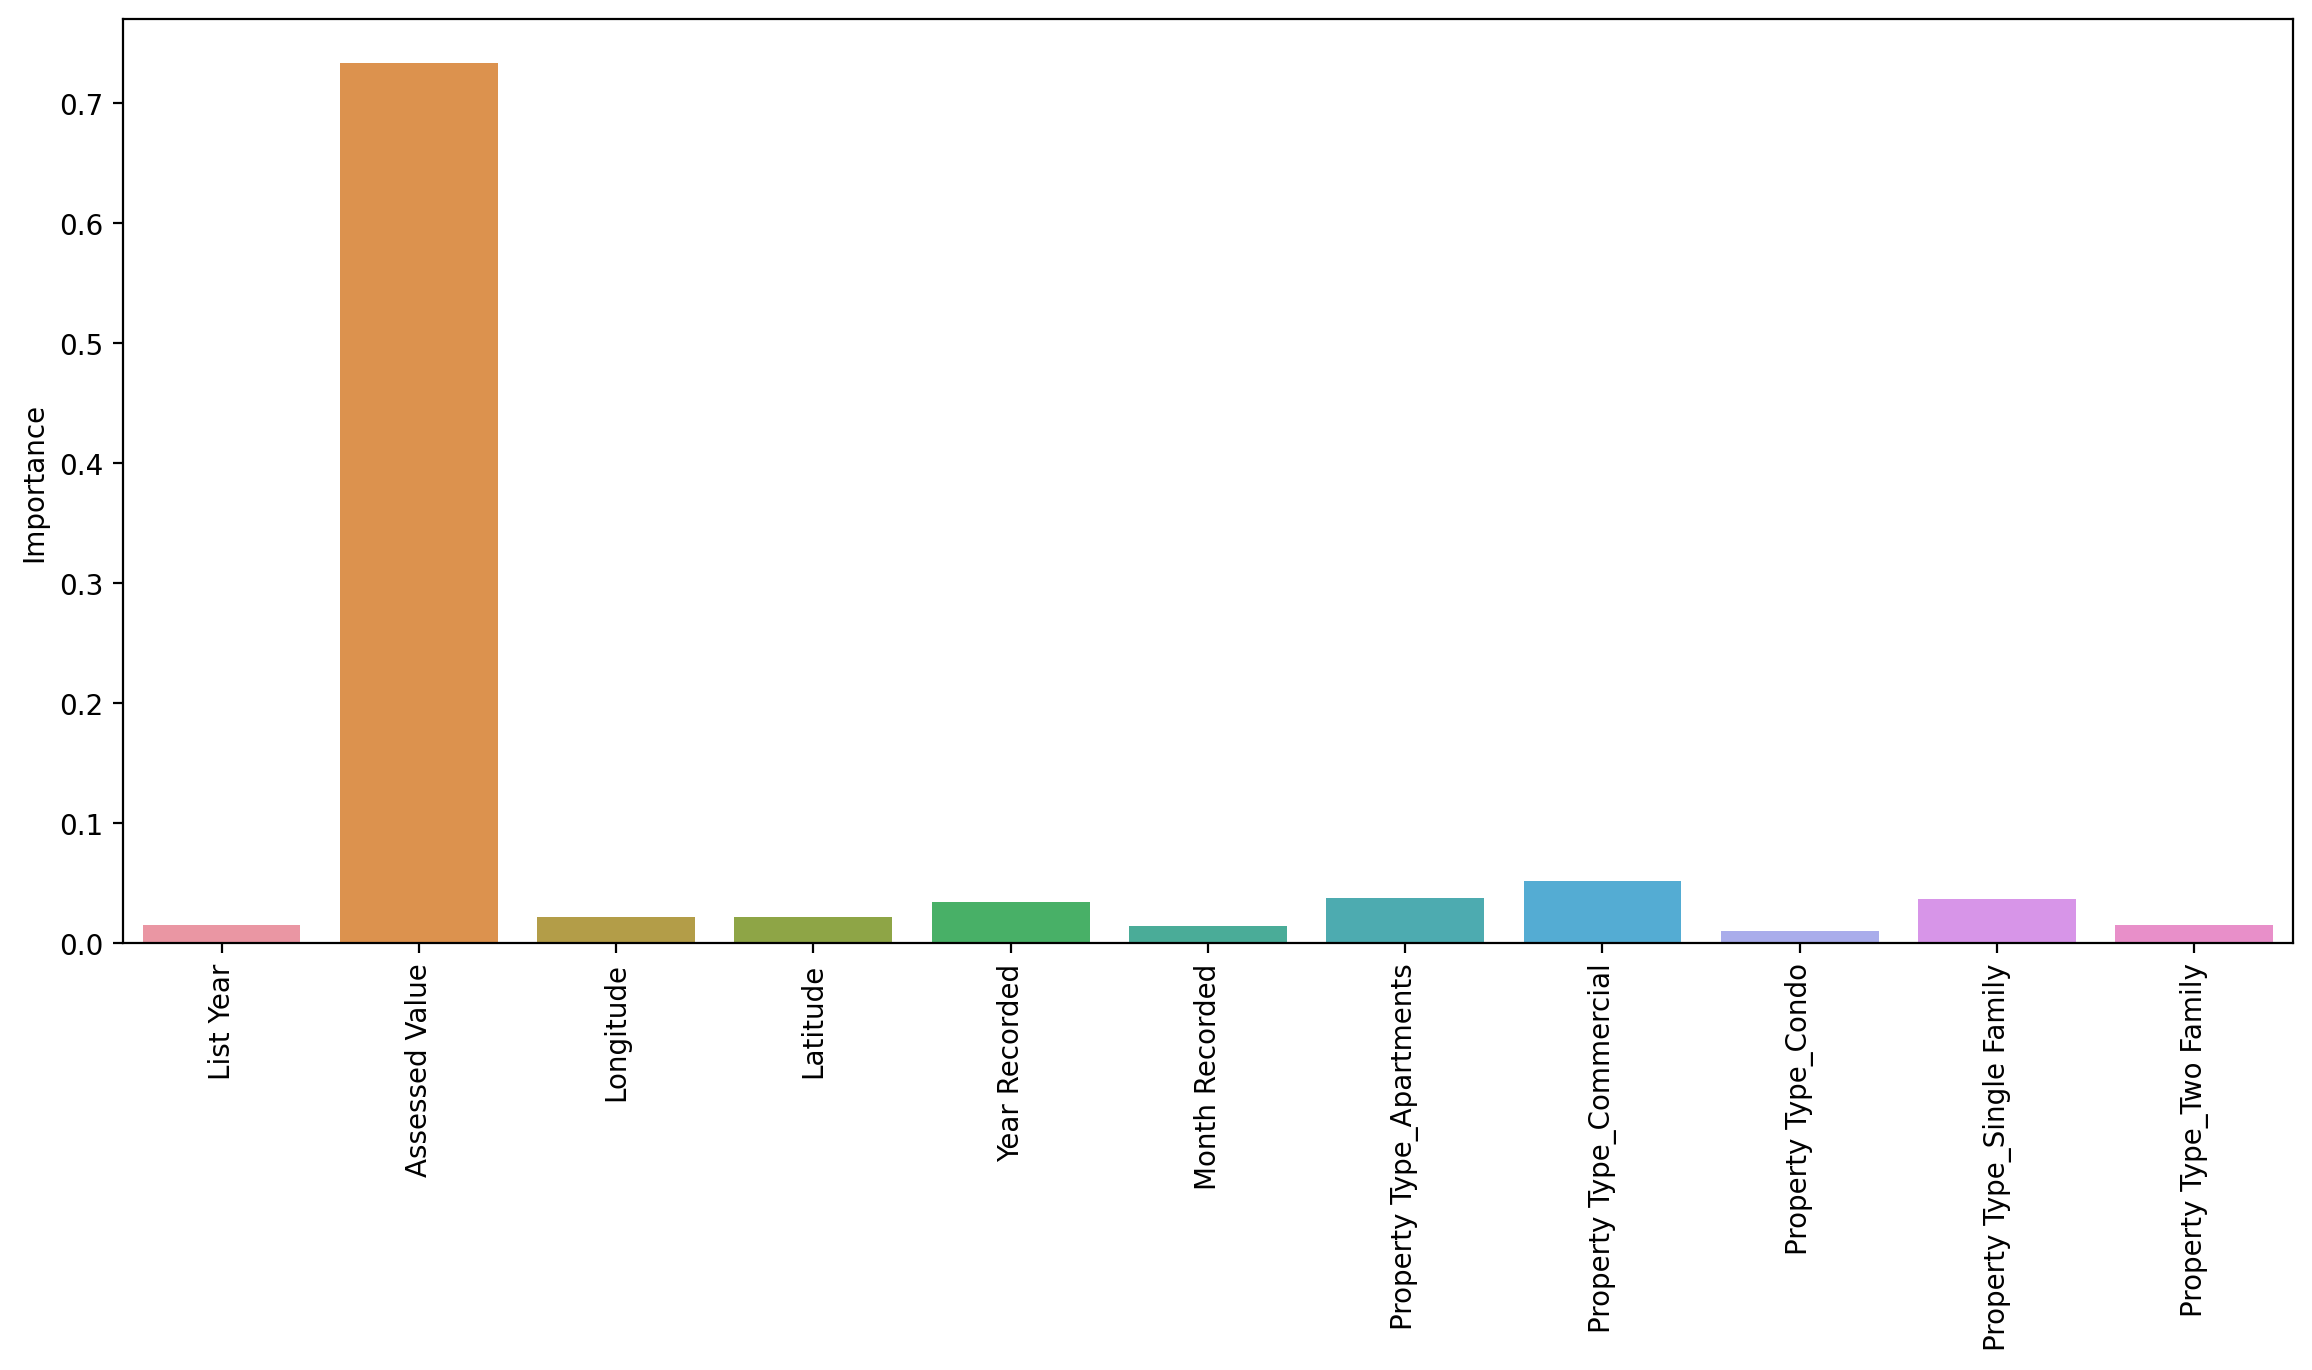

In [205]:
import seaborn as sns

importance_of_var= xgb.feature_importances_
df_importances= pd.DataFrame(data= importance_of_var,
                            columns= ['Importance'], 
                             index= X_train.columns)
df_importances= df_importances[df_importances['Importance'] > 0.01]



plt.figure(figsize= (14, 6), dpi= 200)
sns.barplot(data= df_importances.sort_values('Importance'),
           x= df_importances.index, y= df_importances['Importance'])
plt.xticks(rotation= 90);